In [1]:
# define logging and working directory
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.notebook_imports import *
from pyforest import *

from sklearn.manifold import TSNE

# define GPU id to use
# 0 = 1080 Bus ID 2
# 1 = Titan Bus ID 131
# 2 = Titan Bus ID 132
GPU_IDS = '0'
current_gpu = choose_gpu_by_id(GPU_IDS)
print(current_gpu)

%matplotlib inline
%reload_ext autoreload
%autoreload 2

from src.utils.utils_io import Console_and_file_logger, ensure_dir
from src.utils.myshow import myshow, myshow3d
from src.visualization.visualize import plot_3d_vol, plot_4d_vol, show_slice, show_slice_transparent, show_2D_or_3D, create_quiver_plot
from src.data.dataset import get_metadata_maybe, filter_4d_vol, describe_sitk
from src.data.dataset import get_img_msk_files_from_split_dir, load_acdc_files
from src.data.generators import DataGenerator, get_samples, VAEFlowfieldGenerator, VAEImageGenerator
from src.utils.KerasCallbacks import get_callbacks
from keras.utils import plot_model
from src.models.vae import get_vae
from src.utils.utils_io import Console_and_file_logger, init_config
from src.data.preprocess import normalise_image
Console_and_file_logger('3D_VAE_ED_ES', logging.INFO)

search for root_dir and set working directory
Working directory set to: /mnt/data/git/cardio


Using TensorFlow backend.
2019-12-03 16:15:17,598 INFO -------------------- Start --------------------
2019-12-03 16:15:17,598 INFO Working directory: /mnt/data/git/cardio.
2019-12-03 16:15:17,599 INFO Log file: ./logs/3D_VAE_ED_ES.log


['gpu(0)']


In [2]:
# create a config
EXPERIMENT = 'motion/3D/gcn_vs_acdc/vae_es_ed_myo'
now = datetime.datetime.now()
# image params
DIM = [16, 224, 224]
SPACING = [6, 1.0,1.0] # used by sitk, opposite order than numpy or tensorflow!
# Greyscale images
IMG_CHANNELS = 3    # <------------------ change this to 1 for CMR images
LATENT_DIM = 10
# RV = 1 = Y[...,0] 
# Myo = 2 = Y[...,1] 
# LV = 3 = Y[...,2]
MASK_VALUES = [0, 1, 2, 3]  
MASK_CLASSES = len(MASK_VALUES)
ARCHITECTURE = '3D'
AUGMENT = False
SHUFFLE = True
AUGMENT_GRID = False
SEED = 42
BATCHSIZE =  1 # 64, 16, 1
SCALER = 'MinMax'
EPOCHS = 150

MASK_IMAGE = False
MSE = True # default False
WEIGHTS = False
LEARNING_RATE = 0.0001
FLOW = True

# path params
DATASET = 'gcn'  # 'acdc' # or 'tetra'
TRAIN_PATH = 'data/raw/tetra/2D/train/'
VAL_PATH = 'data/raw/tetra/2D/val/'
TEST_PATH = 'data/raw/tetra/2D/test/'

MODEL_PATH = os.path.join(os.path.join('models', EXPERIMENT), str(now.strftime("%Y-%m-%d_%H_%M")))
TENSORBOARD_LOG_DIR = os.path.join(os.path.join('reports/tensorboard_logs', EXPERIMENT),str(now.strftime("%Y-%m-%d_%H_%M")))
CONFIG_PATH = os.path.join(os.path.join('reports/configs/',EXPERIMENT),str(now.strftime("%Y-%m-%d_%H_%M")))
HISTORY_PATH = os.path.join(os.path.join('reports/history/',EXPERIMENT),str(now.strftime("%Y-%m-%d_%H_%M")))

config = dict(((key, value) for key, value in locals().items()
               if key.isupper() and key not in ['HTML', 'K']))
config = init_config(locals(), True)

In [3]:
# gcn 3d data
df_sys = pd.read_csv('reports/vae/3d_gcn_systolic_flowfield.csv')
print(df_sys.shape)
#df_dia = pd.read_csv('reports/vae/3d_acdc_systolic_flowfield.csv')
#print(df_dia.shape)
#df = pd.concat([df_sys, df_dia], sort=False)
df = df_sys
print(df.shape)
df.phase.unique()
df.head()

(203, 152)
(203, 152)


array(['ES'], dtype=object)

,Unnamed: 0,Unnamed: 0.1,background,rv,myo,lv,y_path,t,t_norm,y_path.1,...,tricuspid insufficiency grades 0-4 tricinsuf,Last Report Date_y,PVR nach MRT y/n,Date PVR,Outcome y/n,Type Outcome_y,Date Outcome,patient_unique,phase,flowfield_3d_gcn
0,1,1,11589,98,35,37,data/raw/GCN/3D/train/0003-04NEJQUZ-2007-03-13...,12,1,data/raw/GCN/3D/train/0003-04NEJQUZ-2007-03-13...,...,3.0,2018-01-02 00:00:00,y (Homograft),2011-10-11 00:00:00,n,NaN,NaN,04NEJQUZ-2007-03-13,ES,data/interim/motion/3d/gcn/es_ed_myo/flowfield...
1,6,6,7076,166,110,81,data/raw/GCN/3D/train/0006-0AE4R74L-1900-01-01...,3,1,data/raw/GCN/3D/train/0006-0AE4R74L-1900-01-01...,...,NaN,2016-05-25 00:00:00,n,NaN,n,"atrial flutter first occured 07/2002, since th...",NaN,0AE4R74L-1900-01-01,ES,data/interim/motion/3d/gcn/es_ed_myo/flowfield...
2,11,11,10521,145,57,56,data/raw/GCN/3D/train/0007-0HQQW4ZN-2007-05-23...,10,1,data/raw/GCN/3D/train/0007-0HQQW4ZN-2007-05-23...,...,1.0,2016-10-12 00:00:00,y (Sapien),2016-10-12 00:00:00,y,slow VT 06/2016,2016-06-01 00:00:00,0HQQW4ZN-2007-05-23,ES,data/interim/motion/3d/gcn/es_ed_myo/flowfield...
3,17,17,11228,143,63,64,data/raw/GCN/3D/train/0008-0PTV75MP-2005-06-27...,7,2,data/raw/GCN/3D/train/0008-0PTV75MP-2005-06-27...,...,NaN,2017-09-14 00:00:00,n,NaN,n,NaN,NaN,0PTV75MP-2005-06-27,ES,data/interim/motion/3d/gcn/es_ed_myo/flowfield...
4,21,21,10953,183,127,62,data/raw/GCN/3D/train/0010-0RPELLU8-2007-02-13...,6,1,data/raw/GCN/3D/train/0010-0RPELLU8-2007-02-13...,...,1.0,2017-06-01 00:00:00,y (Homograft),2008-09-23 00:00:00,n,NaN,NaN,0RPELLU8-2007-02-13,ES,data/interim/motion/3d/gcn/es_ed_myo/flowfield...


In [4]:
#batch_generator = DataGenerator(x=df['x_path'], y=df['y_path'], config=config)

In [5]:
# load images
#batch_generator = VAEImageGenerator(x=df['x_path'], y=df['y_path'], config=config)

In [4]:
# load flowfields
from src.data.generators import VAEFlowfieldGenerator, VAEImageGenerator
batch_generator = VAEFlowfieldGenerator(x=df['flowfield_3d_gcn'], y=df['flowfield_3d_gcn'], config=config)

2019-12-02 21:38:31,543 INFO Create DataGenerator
2019-12-02 21:38:31,544 INFO Datagenerator created with: 
 shape: [16, 224, 224]
 batchsize: 1
 Scaler: MinMax
 Images: 203 
 Augment_grid: False 
 Thread workers: 1
2019-12-02 21:38:31,545 INFO No augmentation


In [5]:
# Select batch generator output
x = ''
y = ''
@interact
def select_batch(batch = (0,len(batch_generator), 1)):
    global x, y
    x, y = batch_generator.__getitem__(batch)
    print(x.shape)
    if y is not None:
        print(y.shape)


interactive(children=(IntSlider(value=101, description='batch', max=203), Output()), _dom_classes=('widget-int…

In [6]:
@interact_manual
def select_image_in_batch(im = (0,config['BATCHSIZE']- 1, 1)):
    
    from src.data.preprocess import normalise_image
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    print(x[im].shape)
    if x.shape[-1] == 1:
        if y is not None:
            show_2D_or_3D(x[im], y[im])
        else:
            show_2D_or_3D(x[im])
    else:
        fig, axes = plt.subplots(1,len(x[im]),  figsize=(5*len(x[im]), 8))
        axes = axes.flatten()
        for ax, flow_slice in zip(axes, x[im]):
            flow_slice = normalise_image(flow_slice)
            ax.imshow(flow_slice);
    #
    plt.show();

interactive(children=(IntSlider(value=0, description='im', max=0), Button(description='Run Interact', style=Bu…

In [7]:
import keras.backend as K
K.clear_session()
encoder, decoder, vae = get_vae(config)
callbacks = get_callbacks(config, batch_generator)

2019-12-02 21:57:57,158 INFO feed 4 Tensorboard is ready


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 16, 224, 224, 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 8, 112, 112,  2624        encoder_input[0][0]              
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 4, 56, 56, 64 55360       conv3d_1[0][0]                   
__________________________________________________________________________________________________
conv3d_3 (Conv3D)               (None, 2, 28, 28, 12 221312      conv3d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

In [8]:
# fit model with trainingsgenerator
logging.info('Fit model')
results = vae.fit_generator(
    generator=batch_generator,
    epochs=config.get('EPOCHS', 10),
    steps_per_epoch = len(batch_generator), # //2 + 10,
    callbacks=callbacks,
    initial_epoch=config.get('INITIAL_EPOCH', 0),
    max_queue_size=30,
    workers=20,
    verbose=1)


2019-12-02 21:58:06,177 INFO Fit model


Epoch 1/150
203/203 [==============================] - 12s 62ms/step - loss: 42.0969


2019-12-02 21:58:21,194 INFO Saved model to disk: models/motion/3D/gcn_vs_acdc/vae_es_ed_myo/2019-12-02_21_37



Epoch 00001: loss improved from inf to 42.09694, saving model to models/motion/3D/gcn_vs_acdc/vae_es_ed_myo/2019-12-02_21_37/checkpoint.h5
Epoch 2/150
203/203 [==============================] - 9s 46ms/step - loss: 22.7701

Epoch 00002: loss improved from 42.09694 to 22.77013, saving model to models/motion/3D/gcn_vs_acdc/vae_es_ed_myo/2019-12-02_21_37/checkpoint.h5
Epoch 3/150
203/203 [==============================] - 9s 47ms/step - loss: 20.1633

Epoch 00003: loss improved from 22.77013 to 20.16328, saving model to models/motion/3D/gcn_vs_acdc/vae_es_ed_myo/2019-12-02_21_37/checkpoint.h5
Epoch 4/150
203/203 [==============================] - 10s 47ms/step - loss: 18.8517

Epoch 00004: loss improved from 20.16328 to 18.85174, saving model to models/motion/3D/gcn_vs_acdc/vae_es_ed_myo/2019-12-02_21_37/checkpoint.h5
Epoch 5/150
203/203 [==============================] - 9s 47ms/step - loss: 17.1772

Epoch 00005: loss improved from 18.85174 to 17.17724, saving model to models/motion/3D/

In [17]:
plot_model(encoder, to_file='reports/vae_cnn_encoder.png', show_shapes=True)

In [14]:
config

{'TSNE': sklearn.manifold.t_sne.TSNE,
 'GPU_IDS': '0',
 'EXPERIMENT': 'motion/3D/gcn_vs_acdc/vae_es_ed_myo',
 'DIM': [16, 224, 224],
 'SPACING': [6, 1.0, 1.0],
 'IMG_CHANNELS': 3,
 'LATENT_DIM': 10,
 'MASK_VALUES': [0, 1, 2, 3],
 'MASK_CLASSES': 4,
 'ARCHITECTURE': '3D',
 'AUGMENT': False,
 'SHUFFLE': True,
 'AUGMENT_GRID': False,
 'SEED': 42,
 'BATCHSIZE': 1,
 'SCALER': 'MinMax',
 'EPOCHS': 150,
 'MASK_IMAGE': False,
 'MSE': True,
 'WEIGHTS': False,
 'LEARNING_RATE': 0.0001,
 'FLOW': True,
 'DATASET': 'gcn',
 'TRAIN_PATH': 'data/raw/tetra/2D/train/',
 'VAL_PATH': 'data/raw/tetra/2D/val/',
 'TEST_PATH': 'data/raw/tetra/2D/test/',
 'MODEL_PATH': 'models/motion/3D/gcn_vs_acdc/vae_es_ed_myo/2019-12-02_21_37',
 'TENSORBOARD_LOG_DIR': 'reports/tensorboard_logs/motion/3D/gcn_vs_acdc/vae_es_ed_myo/2019-12-02_21_37',
 'CONFIG_PATH': 'reports/configs/motion/3D/gcn_vs_acdc/vae_es_ed_myo/2019-12-02_21_37',
 'HISTORY_PATH': 'reports/history/motion/3D/gcn_vs_acdc/vae_es_ed_myo/2019-12-02_21_37'}

In [3]:
@interact_manual
def load_config_interactive(config_file=sorted(glob.glob('reports/configs/motion/3D/gcn_vs_acdc/vae_es_ed_myo/**/*.json', recursive=False))):
    """
    load config, tranings history and model
    'reports/configs/motion/3D/gcn_vs_acdc/vae_es_ed_myo/2019-12-02_21_37'
    """
    from src.data.Dataset_utils import load_config
    from keras.models import model_from_json
    
    # load config with all params into global namespace
    glob_ = load_config(config_file=config_file, load=False)
    
    # update global namesspace to make config, model and evaluation score accessible
    globals().update(glob_)
    
    logging.info('loading model...')
    encoder, decoder, vae = get_vae(config, load_weights=True)
    globals()['encoder'] = encoder
    globals()['decoder'] = decoder
    globals()['vae'] = vae
    logging.info('Experiment: {}'.format(config['EXPERIMENT']))
    logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))

interactive(children=(Dropdown(description='config_file', options=('reports/configs/motion/3D/gcn_vs_acdc/vae_…

In [4]:
for l in vae.layers:
    print(l.name)

encoder_input
encoder
decoder


# Load ACDC and GCN data
# predict low dimensional space
# reduce dim with T-SNE
# validate T-SNE reduction with K-means
# Scatterplot low dimensional space
# interactively filter ACDC data by z-axis, patients

In [5]:
# load GCN and ACDC in separate generators
pred_config = config.copy()
pred_config['SHUFFLE'] = False
pred_config['BATCHSIZE'] = 1
# reuse the GCN/ACDC files loadad for training

In [6]:
# load gcn data
# gcn 3d data
df_sys = pd.read_csv('reports/vae/3d_gcn_systolic_flowfield.csv')
df_sys.shape
#df_dia = pd.read_csv('reports/vae/3d_acdc_systolic_flowfield.csv')
#df_dia.shape
#df = pd.concat([df_sys, df_dia], sort=False)
df = df_sys
# load flowfields
gcn_generator = VAEFlowfieldGenerator(x=df['flowfield_3d_myo'], y=df['flowfield_3d_myo'], config=pred_config)
df.columns

(203, 153)

2019-12-03 16:15:39,815 INFO Create DataGenerator
2019-12-03 16:15:39,816 INFO Datagenerator created with: 
 shape: [16, 224, 224]
 batchsize: 1
 Scaler: MinMax
 Images: 203 
 Augment_grid: False 
 Thread workers: 1
2019-12-03 16:15:39,817 INFO No augmentation


Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'background', 'rv',
       'myo', 'lv', 'y_path', 't', 't_norm',
       ...
       'tricuspid insufficiency grades 0-4 tricinsuf', 'Last Report Date_y',
       'PVR nach MRT y/n', 'Date PVR', 'Outcome y/n', 'Type Outcome_y',
       'Date Outcome', 'patient_unique', 'phase', 'flowfield_3d_myo'],
      dtype='object', length=153)

# Get X, low dim and predictions from the VAE

In [7]:
# get preprocessed x as nda - gcn
x_trains_gcn = []
for gcn_batch in gcn_generator:
    x_trains_gcn.append(gcn_batch[0])
x_trains_gcn = np.concatenate(x_trains_gcn, axis=0)
print('X shape: {}'.format(x_trains_gcn.shape))

# get predictions from the VAE model - gcn
preds_gcn = vae.predict_generator(gcn_generator)
print('predictions shape: {}'.format(preds_gcn.shape))

# cut the last slices from dataframe, predictions are smaller, due to rounding of generator length
len(df)
df = df.head(x_trains_gcn.shape[0]).copy()
len(df)

# get means from encoder model - gcn
z_means, z_vars, z = encoder.predict_generator(gcn_generator)
print('z_means shape : {}'.format(z_means.shape))
print('z_var shape : {}'.format(z_vars.shape))
print('z shape : {}'.format(z.shape))

# get all low dim z, z_mean and z_var values and write them into the df
# works with any low dim shape
df['z_mean'] =  z_means.tolist()
zmean = list(zip(*df['z_mean'].values))
print(len(zmean))
for i, z_mean in enumerate(zmean):
    df['z_mean_{}'.format(i)] = z_mean
    
df['z_vars'] =  z_vars.tolist()
zvar = list(zip(*df['z_vars'].values))
print(len(zvar))
for i, z_var in enumerate(zvar):
    df['z_var_{}'.format(i)] = z_var

df['z'] =  z.tolist()
z_ = list(zip(*df['z'].values))
print(len(z_))
for i, z_i in enumerate(z_):
    df['z_{}'.format(i)] = z_i


X shape: (203, 16, 224, 224, 3)
predictions shape: (203, 16, 224, 224, 3)


203

203

z_means shape : (203, 10)
z_var shape : (203, 10)
z shape : (203, 10)
10
10
10


# Plot Z, Z-mean and Z-var

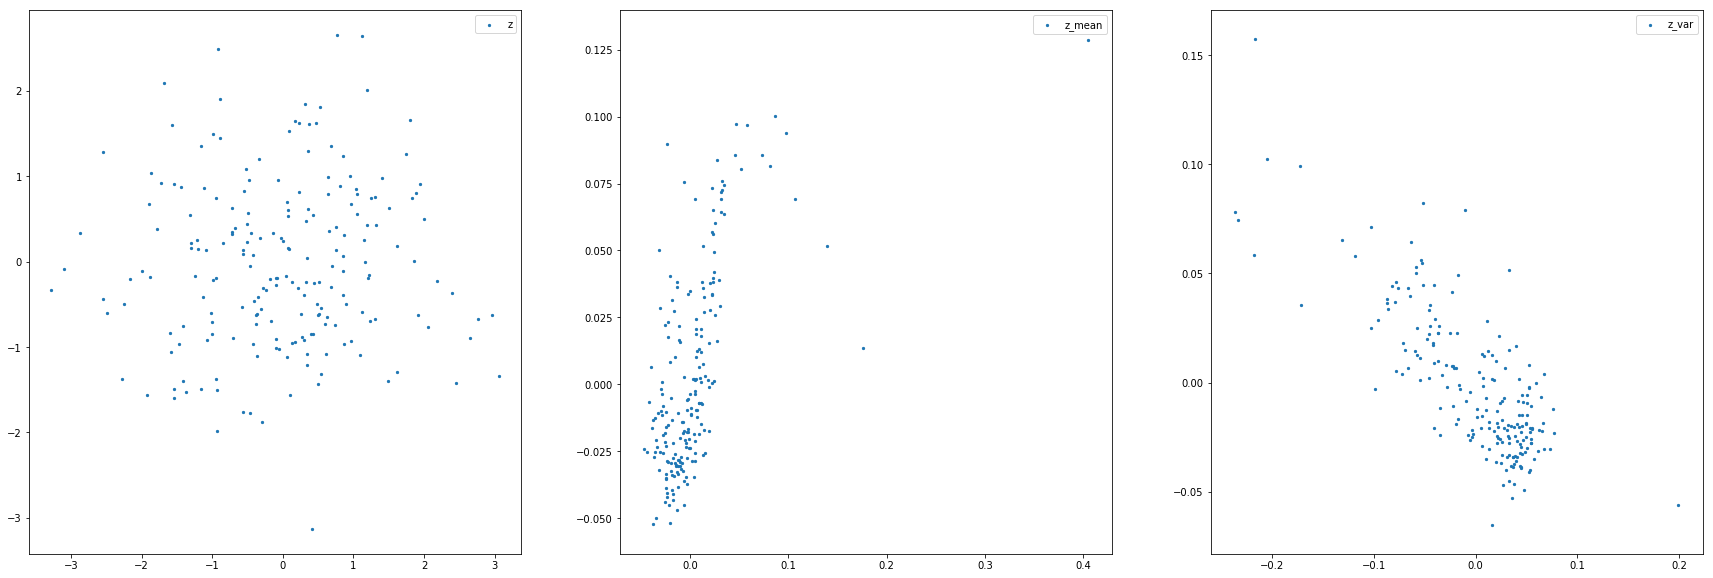

In [8]:
# plot the first two dimenskions of z mean, z var and z

fig, (ax1, ax2, ax3) = plt.subplots(1,3,  figsize=(30,10))

ax1.scatter(df['z_1'], df['z_2'], s=5, label='z'); # z
ax1.legend()

ax2.scatter(df['z_mean_1'], df['z_mean_2'], s=5, label='z_mean'); # z mean
ax2.legend()
ax3.scatter(df['z_var_1'], df['z_var_2'], s=5, label='z_var'); # z var
ax3.legend()

plt.show();

In [9]:
# visualize input and output of the VAE
@interact_manual
def show_input_output(img = (0, x_trains_gcn.shape[0]-1)):
    
    from src.data.preprocess import normalise_image
    
    # get selected image
    selected_input = x_trains_gcn[img]
    selected_output = preds_gcn[img]
    
    # define figure size
    fig, axes = plt.subplots(2,len(selected_input),  figsize=(5*len(selected_output), 8))
    
    # flatten axes to make iteration easier
    axes_top = axes[0].flatten()
    axes_bottom = axes[1].flatten()
    
    # plot each slice of of the input and outout vector field
    for ax_t, ax_b, flow_slice, flow_slice_out in zip(axes_top, axes_bottom, selected_input, selected_output):
        flow_slice = normalise_image(flow_slice)
        ax_t.imshow(flow_slice); # plot vectors as rgb values with matplotlib
        ax_b.imshow(normalise_image(flow_slice_out));
        
        #ax_b = create_quiver_plot(flow_slice, ax_b) #create a 2D quiver plot per slice
    plt.show()

interactive(children=(IntSlider(value=101, description='img', max=202), Button(description='Run Interact', sty…

2019-12-03 16:17:46,133 INFO (203, 10)
2019-12-03 16:17:46,561 INFO (203, 2)
2019-12-03 16:17:46,561 INFO (203, 2)


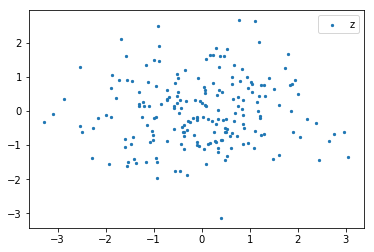

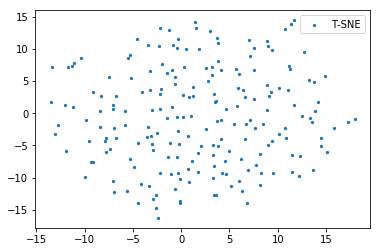

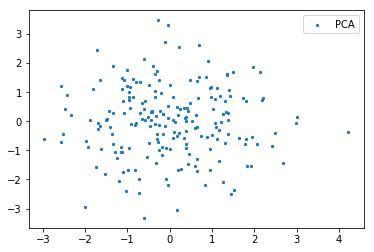

In [12]:
# concat gcn and acdc data, shrink dimensionality by TSNE
# concatenate both
from sklearn.decomposition import PCA
logging.info(z.shape)

# reduce dimensionality
z_tsne = TSNE(n_components=2, perplexity=20, n_iter=10000).fit_transform(z)
z_pca = PCA(n_components=2).fit_transform(z)
logging.info(z_tsne.shape)
logging.info(z_pca.shape)

df['z_tsne'] =  z_tsne.tolist()
z_1, z_2 = list(zip(*df['z_tsne'].values))
df['z_tsne_1'] = z_1
df['z_tsne_2'] = z_2

df['z_pca'] =  z_pca.tolist()
z_1, z_2 = list(zip(*df['z_pca'].values))
df['z_pca_1'] = z_1
df['z_pca_2'] = z_2

# scatter low dim vectors of acdc and gcn slices
plt.scatter(df['z_1'], df['z_2'], s=5, label='z'); # z
plt.legend()
plt.show();

plt.scatter(df['z_tsne_1'], df['z_tsne_2'], s=5, label='T-SNE'); # z t-sne
plt.legend()
plt.show();

plt.scatter(df['z_pca_1'], df['z_pca_2'], s=5, label='PCA'); # z pca
plt.legend()
plt.show();

In [13]:
# plot correlations of low dimensional space select group to sort by
from ipywidgets import interact_manual
@interact_manual
def show_correlations_of_low_dimensional_space(group=df.columns.values[3:]):
    
    # maximal numbers of bins
    max_bins = 5
    
    cols_pca = ['z_pca_1', 'z_pca_2'] + [group]
    temp_pca = df[cols_pca].copy()
    
    cols_tsne = ['z_tsne_1', 'z_tsne_2'] + [group]
    temp_tsne = df[cols_tsne].copy()
    
    if(temp_pca[group].dtype == np.float64 or temp_pca[group].dtype == np.int64):
        # transform numeric values to categorical with maximal 5 bins to avoid comuputation leaks
        temp_pca[group] = pd.cut(temp_pca[group], bins=min(len(temp_pca[group].unique()),max_bins))
        
    if(temp_tsne[group].dtype == np.float64 or temp_tsne[group].dtype == np.int64):
     #   # transform numeric values to categorical with maximal 5 bins to avoid comuputation leaks
        temp_tsne[group] = pd.cut(temp_tsne[group], bins=min(len(temp_tsne[group].unique()),max_bins))
    
    g = sns.pairplot(temp_tsne, hue=group, height=3)
    g = sns.pairplot(temp_pca, hue=group, height=3)

interactive(children=(Dropdown(description='group', options=('background', 'rv', 'myo', 'lv', 'y_path', 't', '…

# Apply T-SNE on VAE low dimensional vectors

In [14]:
# extract all values per low dimensional representation and write them as column in our dataframe
for dim_idx in range(z.shape[-1]):
    print('found low dim:', dim_idx)
    dims = z[:,dim_idx]
    column_dim_name = 'low_dim_{}of{}'.format(dim_idx, z.shape[-1])
    df[column_dim_name] = dims

found low dim: 0
found low dim: 1
found low dim: 2
found low dim: 3
found low dim: 4
found low dim: 5
found low dim: 6
found low dim: 7
found low dim: 8
found low dim: 9


In [16]:
# simple SVM test for Outcome class

In [17]:
# filter out rows with nans in the outcome column
df_ = df[df['Outcome y/n'].isin(['y','n'])]
df_.shape

(183, 202)

In [230]:
# collect only the low dimensional representation
cols = cols_tsne = ['z_tsne_1', 'z_tsne_2'] + ['Outcome y/n']
temp = df_[cols]
temp.head()
temp.shape

,z_tsne_1,z_tsne_2,Outcome y/n
0,1.780205,-6.148215,n
1,-4.618647,11.462717,n
2,-1.289104,12.896195,y
3,0.291051,7.138401,n
4,7.130851,8.842896,n


(183, 3)

In [225]:
# collect the low dimensional z values, use the filtered dataframe
cols = [col for col in df_.columns if 'low_dim' in col] + ['Outcome y/n']
temp = df_[cols]
temp.shape
temp.head()

(183, 11)

,low_dim_0of10,low_dim_1of10,low_dim_2of10,low_dim_3of10,low_dim_4of10,low_dim_5of10,low_dim_6of10,low_dim_7of10,low_dim_8of10,low_dim_9of10,Outcome y/n
0,-1.643638,-0.379894,-0.626623,0.795236,-1.344614,0.512478,-0.149275,-0.501477,0.026696,0.629216,n
1,0.554098,0.075709,0.603347,-1.437762,-0.500510,1.038196,0.651524,-0.372848,0.832567,-2.510832,n
2,0.365995,-1.024313,-0.597624,0.610293,0.928928,-1.166241,-0.767497,1.554212,-0.789560,-2.016550,y
3,0.000122,0.006655,0.237046,-0.485900,-0.017315,-1.080210,0.586238,-0.158593,0.362653,-1.004075,n
4,0.570195,-0.894978,1.450278,0.286166,1.375068,0.055726,-0.955635,-1.657327,0.508110,-0.928471,n


In [148]:
from collections import Counter
Counter(df_['Outcome y/n'])

Counter({'n': 171, 'y': 12})

In [231]:
# split the data in train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    temp[temp.columns[:-1]].values, temp[temp.columns[-1]].values, test_size=0.25, random_state=42)
Counter(y_train)
Counter(y_test)

Counter({'n': 129, 'y': 8})

Counter({'y': 4, 'n': 42})

In [185]:
from sklearn.svm import SVC, LinearSVC
from sklearn import tree
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

#clf = GaussianNB()
#clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1, max_iter=1000)
#clf = ExtraTreesClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0, class_weight={'n': 1, 'y': 10})
#clf = RandomForestClassifier(n_estimators=10, class_weight={'n': 1, 'y': 20})
#clf = SGDClassifier(loss="hinge", penalty="l2", tol=1e-3,max_iter=50, class_weight={'n': 1, 'y': 10})
clf = tree.DecisionTreeClassifier(class_weight={'n': 1, 'y': 20})

#clf = LinearSVC(class_weight={'n': 1, 'y': 20})
#clf = SVC(kernel='rbf', class_weight={'n': 1, 'y': 20})
#clf = SVC(kernel='poly', class_weight={'n': 1, 'y': 20})
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={'n': 1, 'y': 20},
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

In [186]:
clf.score(X_train, y_train)

1.0

In [187]:
clf.score(X_test, y_test)

0.8260869565217391

In [188]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

confusion_matrix(y_test, y_pred_test, labels=['n','y'])

              precision    recall  f1-score   support

           n       1.00      1.00      1.00       129
           y       1.00      1.00      1.00         8

    accuracy                           1.00       137
   macro avg       1.00      1.00      1.00       137
weighted avg       1.00      1.00      1.00       137

              precision    recall  f1-score   support

           n       0.90      0.90      0.90        42
           y       0.00      0.00      0.00         4

    accuracy                           0.83        46
   macro avg       0.45      0.45      0.45        46
weighted avg       0.83      0.83      0.83        46



array([[38,  4],
       [ 4,  0]])

[Text(313.875, 764.4375, 'X[9] <= -3.083\ngini = 0.012\nsamples = 137\nvalue = [2580, 16]'),
 Text(244.125, 662.5125, 'gini = 0.0\nsamples = 1\nvalue = [0, 2]'),
 Text(383.625, 662.5125, 'X[9] <= 2.584\ngini = 0.011\nsamples = 136\nvalue = [2580, 14]'),
 Text(313.875, 560.5875, 'X[1] <= -2.826\ngini = 0.009\nsamples = 135\nvalue = [2580, 12]'),
 Text(139.5, 458.66249999999997, 'X[3] <= 1.072\ngini = 0.165\nsamples = 2\nvalue = [20, 2]'),
 Text(69.75, 356.7375, 'gini = 0.0\nsamples = 1\nvalue = [20, 0]'),
 Text(209.25, 356.7375, 'gini = 0.0\nsamples = 1\nvalue = [0, 2]'),
 Text(488.25, 458.66249999999997, 'X[1] <= -1.017\ngini = 0.008\nsamples = 133\nvalue = [2560, 10]'),
 Text(348.75, 356.7375, 'X[1] <= -1.05\ngini = 0.032\nsamples = 28\nvalue = [480, 8]'),
 Text(279.0, 254.8125, 'X[9] <= 1.038\ngini = 0.024\nsamples = 27\nvalue = [480, 6]'),
 Text(209.25, 152.88750000000005, 'gini = 0.0\nsamples = 20\nvalue = [400, 0]'),
 Text(348.75, 152.88750000000005, 'X[4] <= -0.477\ngini = 0.13\n

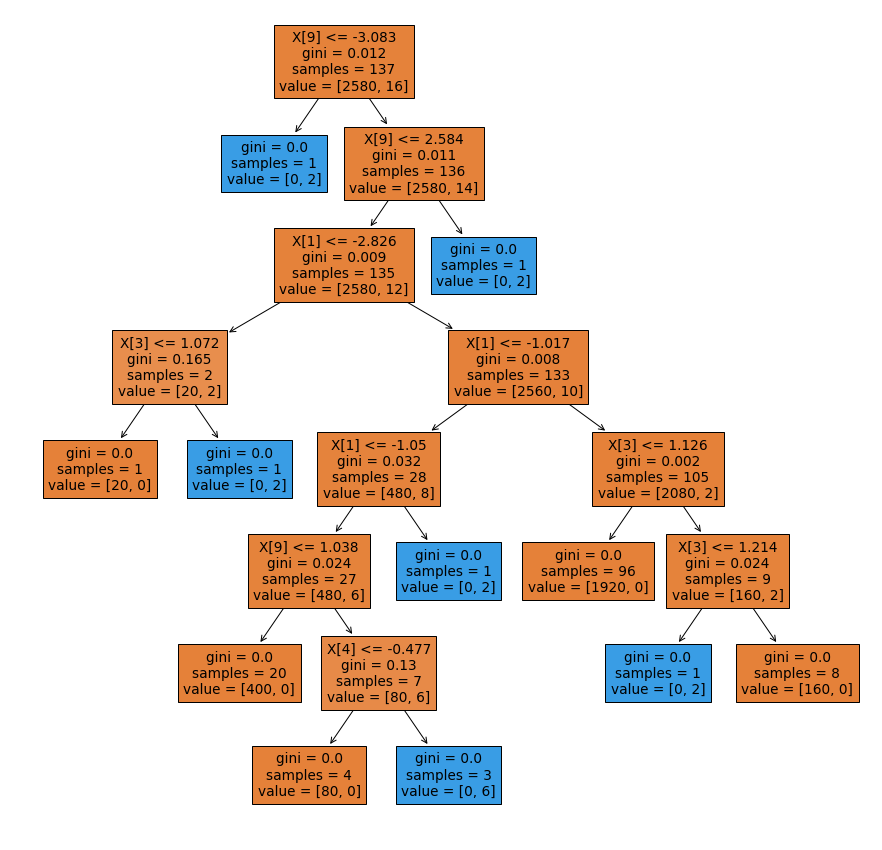

In [184]:
# plot the decission tree
from sklearn.tree import plot_tree
fix, ax = plt.subplots(1, figsize=(15,15))
plot_tree(clf.fit(X_train, y_train), filled=True, ax=ax) 

In [232]:
y_train_numeric = [0 if elem=='n' else 1 for elem in y_train]

In [190]:
X_train.shape[1]

10

Text(0.5, 926.4352941176471, '0')

Text(153.125, 0.5, '1')

Text(0.5, 942.6666666666665, '1')

Text(481.02083333333326, 0.5, '2')

Text(0.5, 951.9999999999999, '2')

Text(957.6250000000001, 0.5, '3')

Text(0.5, 478.0, '3')

Text(33.87500000000001, 0.5, '4')

Text(0.5, 479.4999999999999, '4')

Text(498.8749999999999, 0.5, '5')

Text(0.5, 479.50000000000006, '5')

Text(963.8750000000001, 0.5, '6')

Text(0.5, 4.000000000000071, '6')

Text(33.87500000000001, 0.5, '7')

Text(0.5, 20.99999999999985, '7')

Text(498.8749999999999, 0.5, '8')

Text(0.5, 34.99999999999996, '8')

Text(963.8750000000001, 0.5, '9')

Text(0.5, 0.98, 'Decision surface of a decision tree using paired features')

(-3.415048360824585, 3.144951639175421, -4.150892496109009, 3.609107503890826)

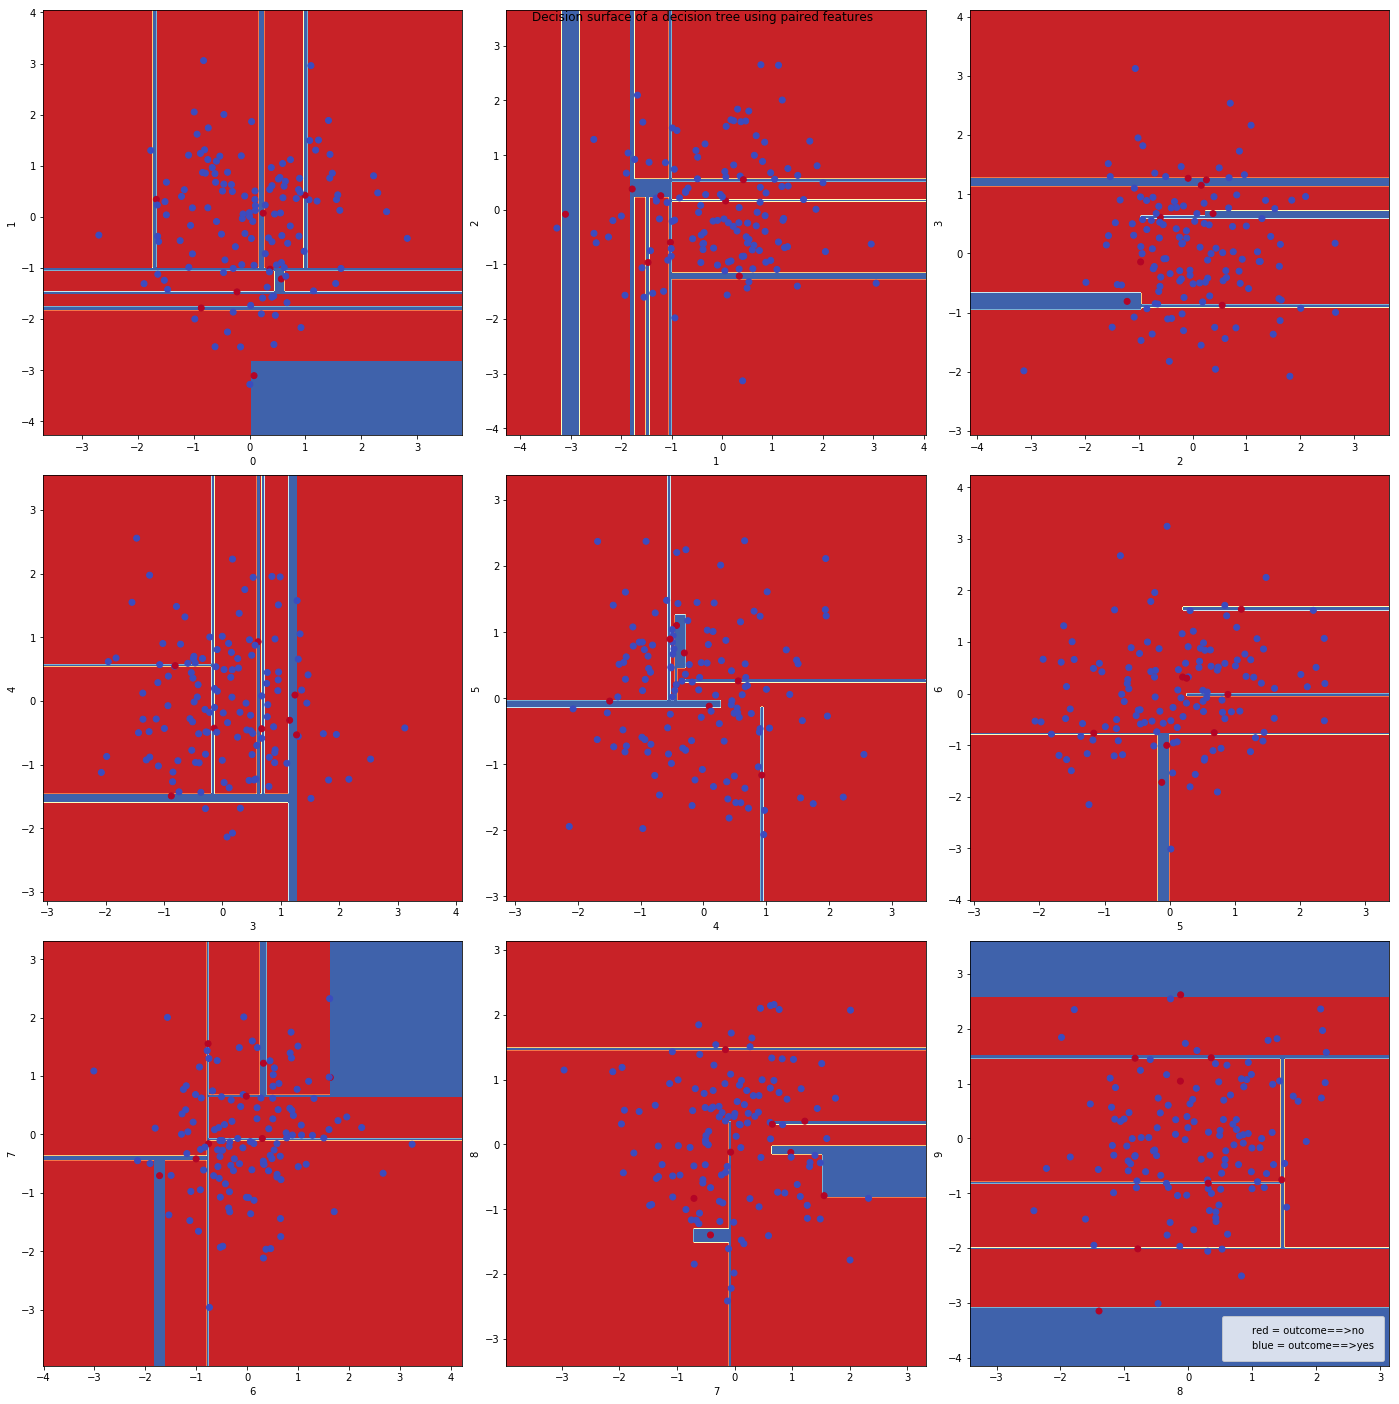

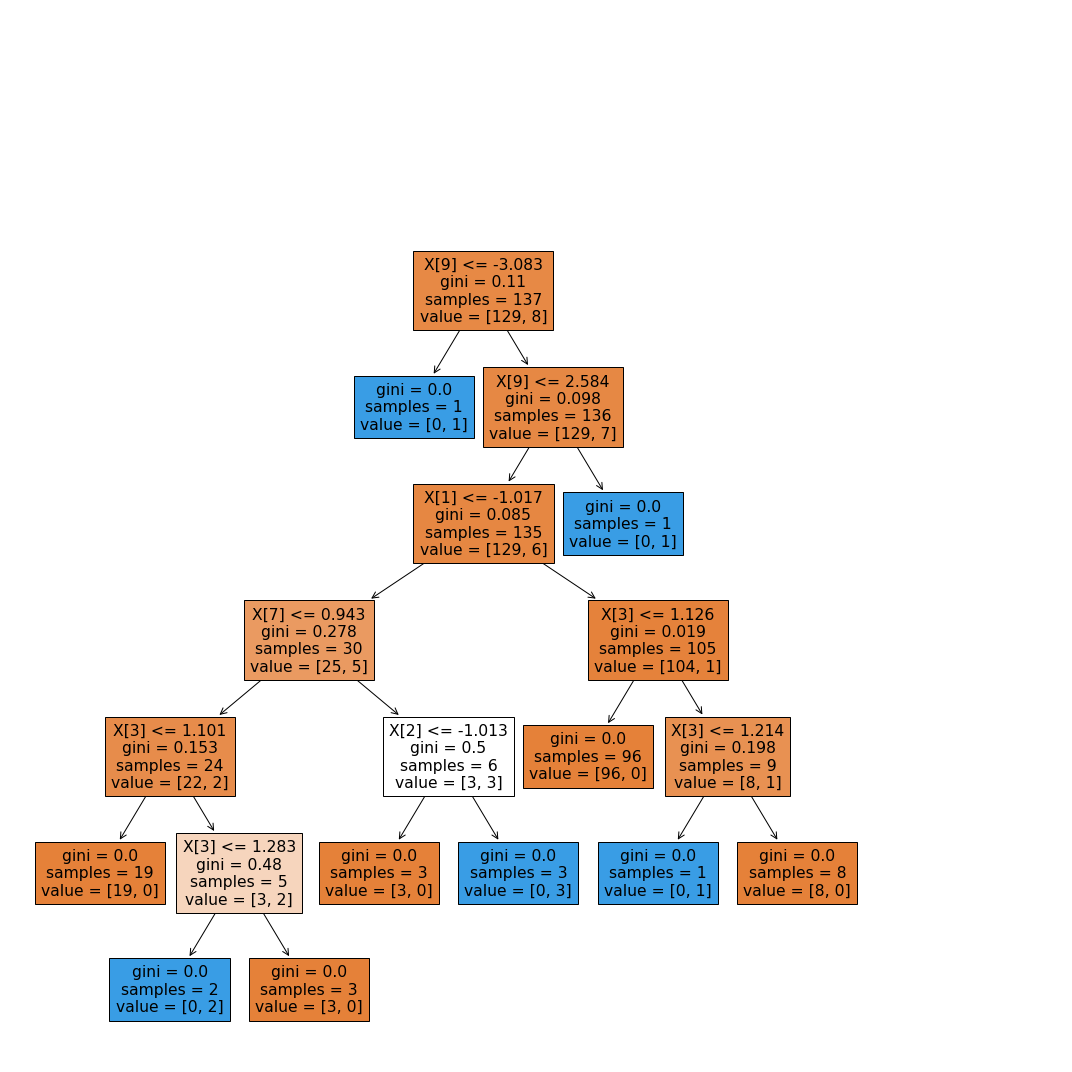

In [228]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Parameters
n_classes = 2
plot_colors = "ryb"
plot_step = 0.02

start = 0
stop = X_train.shape[1]-1
step = 1

ranges = [[n, min(n+step, stop)] for n in range(start, stop, step)]
fig = plt.figure(figsize=(20,20))
for pairidx, pair in enumerate(ranges):
    # We only take the two corresponding features
    X = X_train[:, pair]
    y = y_train_numeric

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    
    plt.subplot(3, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu);
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color,
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15);

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=1, handletextpad=0, labels=['red = outcome==>no','blue = outcome==>yes'])
plt.axis("tight")

fix, ax = plt.subplots(1, figsize=(15,15))
clf = DecisionTreeClassifier().fit(X_train, y_train_numeric)
a = plot_tree(clf, filled=True, ax=ax)
plt.tight_layout()
plt.show()

'iris.pdf'

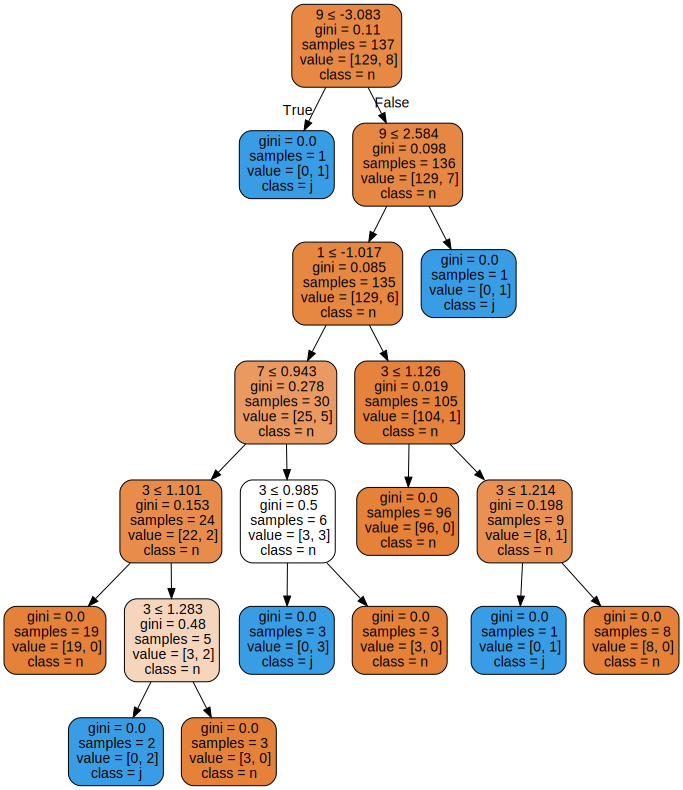

In [222]:
import graphviz
# save the tree as pdf
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=range(0,10,1),  
                     class_names=['n','j'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data) 
graph.render("reports/outcome_tree") 

# render the tree in jupyter
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=range(0,10,1),  
                     class_names=['n','j'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0.5, 0, 'Sepal length')

Text(0, 0.5, 'Sepal width')

(-14.512516975402832, 18.307483024596465)

(-17.254589080810547, 14.805410919188773)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5, 1.0, 'SVC with linear kernel')

Text(0.5, 0, 'Sepal length')

Text(0, 0.5, 'Sepal width')

(-14.512516975402832, 18.307483024596465)

(-17.254589080810547, 14.805410919188773)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5, 1.0, 'LinearSVC (linear kernel)')

Text(0.5, 0, 'Sepal length')

Text(0, 0.5, 'Sepal width')

(-14.512516975402832, 18.307483024596465)

(-17.254589080810547, 14.805410919188773)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5, 1.0, 'SVC with RBF kernel')

Text(0.5, 0, 'Sepal length')

Text(0, 0.5, 'Sepal width')

(-14.512516975402832, 18.307483024596465)

(-17.254589080810547, 14.805410919188773)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5, 1.0, 'SVC with polynomial (degree 3) kernel')

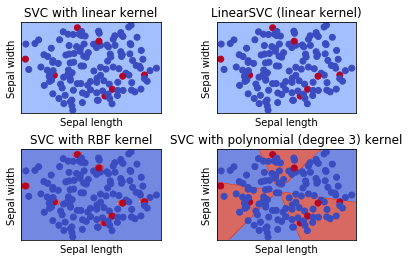

In [233]:

from sklearn import svm

X = X_train
y = y_train_numeric

X_test = X_test
y_test = [0 if elem=='n' else 1 for elem in y_test]

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C, class_weight={0: 1, 1: 20}, max_iter=10000).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C, class_weight={0: 1, 1: 20}, max_iter=10000).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C, class_weight={0: 1, 1: 20}, max_iter=10000).fit(X, y)
lin_svc = svm.LinearSVC(C=C, class_weight={0: 1, 1: 20}, max_iter=10000).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    #plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.PiYG)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

In [40]:
df['pathology'] = df.pathology.fillna('TOF')

In [234]:
# plot correlations of low dimensional space select group to sort by
from ipywidgets import interact_manual
@interact_manual
def show_correlations_of_low_dimensional_space(group=df.columns.values[3:]):

    #plt.clf()
    g = None
    cols = [col for col in df.columns if 'low_dim' in col] + [group]
    temp = df[cols].copy()

    if(temp[group].dtype == np.float64 or temp[group].dtype == np.int64):
        # transform numeric values to categorical with maximal 5 bins to avoid comuputation leaks
        temp[group] = pd.cut(temp[group], bins=min(len(temp[group].unique()),5))

    # create a pairplot
    g = sns.pairplot(temp, hue=group, height=3)
    
    cols_tsne = ['z_tsne_1', 'z_tsne_2'] + [group]
    temp_tsne = df[cols_tsne].copy()
    
    g = sns.pairplot(temp_tsne, hue=group, height=3)

interactive(children=(Dropdown(description='group', options=('background', 'rv', 'myo', 'lv', 'y_path', 't', '…

In [25]:
# interpolate from low dimenaional space (ndims=5) and predict Flowfield
@interact
def show_correlations_and_interpolate_from_low_dim(dim0=(df['z_mean'].map(lambda x : x[0]).min(),
                                   df['z_mean'].map(lambda x : x[0]).max()),
                             dim1=(df['z_mean'].map(lambda x : x[1]).min(),
                                     df['z_mean'].map(lambda x : x[1]).max()),
                             dim2=(df['z_mean'].map(lambda x : x[2]).min(),
                                     df['z_mean'].map(lambda x : x[2]).max()),
                             dim3=(df['z_mean'].map(lambda x : x[3]).min(),
                                     df['z_mean'].map(lambda x : x[3]).max()),
                             dim4=(df['z_mean'].map(lambda x : x[4]).min(),
                                     df['z_mean'].map(lambda x : x[4]).max()),
                             group=df.columns.values[3:],
                            plot=False,
                            predict_flow_field=False):
    
    #plt.clf()
    g = None
    cols = [col for col in df.columns if 'low_dim' in col] + [group]
    temp = df[cols].copy()
    print(temp[group].dtype)
    if(temp[group].dtype == np.float64 or temp[group].dtype == np.int64):
        temp[group] = pd.cut(temp[group], bins=min(len(temp[group].unique()),5))
    print(temp[group].dtype)
    #temp[group] = pd.Categorical(temp[group])
    if plot:
        # create a pairplot
        g = sns.pairplot(temp, hue=group, height=3)
        
    if g is not None:
        offset = 0
        for i in range(g.axes.shape[0]):

            for j in range(offset, g.axes.shape[1]):

                # draw a marker on each dimension, set marker to 0,0 if no value is given by slider
                dimx = locals().get('dim{}'.format(j), 0)
                dimy = locals().get('dim{}'.format(i), 0)

                g.axes[i,j].scatter(dimx,dimy,color='red', s=200)

            offset = offset + 1
   
        if predict_flow_field:
            
            decoder_input_shape = decoder.get_input_at(0).shape[-1]
            
            # get the selected values from the sliders
            dims = [locals().get('dim{}'.format(i), 0) for i in range(decoder_input_shape)]
            low_dim = np.array(dims)[np.newaxis,...]
            recon = decoder.predict(low_dim)

            if recon[0].shape[-1] == 1: # vizualize 2D or 3D volumes reconstructed from the decoder
                show_2D_or_3D(recon[0])

            else: # vizualize 2D flowmaps from reconstructed 3D flowfields
                fig, axes = plt.subplots(2,len(recon[0]),  figsize=(5*len(recon[0]), 8))
                axes_top = axes[0].flatten()
                axes_bottom = axes[1].flatten()
                for ax_t, ax_b, flow_slice in zip(axes_top, axes_bottom, recon[0]):
                    ax_t.imshow(normalise_image(flow_slice)); # plot vectors as rgb values with matplotlib
                    ax_b = create_quiver_plot(flow_slice*5, ax_b) #create a 2D quiver plot per slice



interactive(children=(FloatSlider(value=0.033182740211486816, description='dim0', max=3.802943706512451, min=-…

In [23]:
# interpolate from low dimenaional space and predict Flowfield, faster without pairplot
@interact_manual
def interpolate_from_low_dim(dim0=(df['z_mean'].map(lambda x : x[0]).min(),
                                   df['z_mean'].map(lambda x : x[0]).max()),
                             dim1=(df['z_mean'].map(lambda x : x[1]).min(),
                                     df['z_mean'].map(lambda x : x[1]).max()),
                             dim2=(df['z_mean'].map(lambda x : x[2]).min(),
                                     df['z_mean'].map(lambda x : x[2]).max()),
                             dim3=(df['z_mean'].map(lambda x : x[3]).min(),
                                     df['z_mean'].map(lambda x : x[3]).max()),
                             dim4=(df['z_mean'].map(lambda x : x[4]).min(),
                                     df['z_mean'].map(lambda x : x[4]).max()),
                             dim5=(df['z_mean'].map(lambda x : x[5]).min(),
                                     df['z_mean'].map(lambda x : x[5]).max()),
                             dim6=(df['z_mean'].map(lambda x : x[6]).min(),
                                     df['z_mean'].map(lambda x : x[6]).max()),
                             dim7=(df['z_mean'].map(lambda x : x[7]).min(),
                                     df['z_mean'].map(lambda x : x[7]).max()),
                             dim8=(df['z_mean'].map(lambda x : x[8]).min(),
                                     df['z_mean'].map(lambda x : x[8]).max()),
                             dim9=(df['z_mean'].map(lambda x : x[9]).min(),
                                     df['z_mean'].map(lambda x : x[9]).max())):
        
    decoder_input_shape = decoder.get_input_at(0).shape[-1]
    dims = [locals().get('dim{}'.format(i), 0) for i in range(decoder_input_shape)]
    low_dim = np.array(dims)[np.newaxis,...]
    recon = decoder.predict(low_dim)

    if recon[0].shape[-1] == 1: # vizualize 2D or 3D volumes reconstructed from the decoder
        show_2D_or_3D(recon[0])

    else: # vizualize 2D flowmaps from reconstructed 3D flowfields
        fig, axes = plt.subplots(2,len(recon[0]),  figsize=(5*len(recon[0]), 8))
        axes_top = axes[0].flatten()
        axes_bottom = axes[1].flatten()
        for ax_t, ax_b, flow_slice in zip(axes_top, axes_bottom, recon[0]):
            ax_t.imshow(flow_slice); # plot vectors as rgb values with matplotlib
            ax_b = create_quiver_plot(flow_slice, ax_b) #create a 2D quiver plot per slice

IndexError: list index out of range

# save and restore dataframe

In [50]:
# save df as temp df fo reusage
df.to_csv('reports/vae/3d_gcn_trained_lowdim_2.csv') # acdc or gcn data

In [19]:
df = pd.read_csv('reports/vae/3d_gcn_trained_lowdim_2.csv')
# transform string of list to list
df['z_mean_tsne_2'] = df['z_mean_tsne_2'].map(lambda x : [float(n) for n in x.strip('[]').split(',')])

In [65]:
# interpolate from 2D low dimensional space
@interact
def scatter_low_dim_filter_by_z(x=(df['z_mean'].map(lambda x : x[0]).min(),
                                   df['z_mean'].map(lambda x : x[0]).max()), 
                                y = (df['z_mean'].map(lambda x : x[1]).min(),
                                     df['z_mean'].map(lambda x : x[1]).max()), 
                                col = df.columns, 
                                predict_flowfield=False):
    
    """
    Plot the low dimensional space of the VAE
    Interpolate and predict flowfields or volumes from that low dimensional space
    group the low dimensional space by the given meta data columns
    """
    
    logging.info('selected x: {}'.format(x))
    logging.info('selected y: {}'.format(y))
    

    # create the first figure for the scatterplot overview
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,8))
    
    # figure one with a scatterplot of the low dimensional space
    ax1.set_title('low dim from VAE rearanged with T-SNE')
    ax1 = sns.scatterplot(df['z_1'], df['z_2'], hue=df[col], ax=ax1)
    ax1 =sns.scatterplot([x], [y], s=500, ax=ax1)
    #ax1 =sns.scatterplot([x], [y], s=500, ax=ax1)
    
    # place the legend beside the plot
    legend_x = 1
    legend_y = 0.5
    box1 = ax1.get_position()
    ax1.set_position([box1.x0, box1.y0, box1.width*0.65, box1.height])
    ax1.legend( loc='center left', bbox_to_anchor=(legend_x, legend_y))
    
    
    ax2.set_title('low dim from VAE')
    ax2 = sns.scatterplot(df['z_mean'].map(lambda x : x[0]), df['z_mean'].map(lambda x : x[1]), hue=df[col], ax=ax2)
    ax2 =sns.scatterplot([x], [y], s=500, ax=ax2)
    
    box2 = ax2.get_position()
    ax2.set_position([box2.x0, box2.y0, box2.width*0.65, box2.height])
    ax2.legend( loc='center left', bbox_to_anchor=(legend_x, legend_y))
    
    if predict_flowfield:
        # interpolate from the low dimensional space, 
        # create a tuple from the selected low dim values 
        # and predict the flowfield for that parameters with the decoder part of the VAE
        low_dim = np.array([x,y])[np.newaxis,...]
        recon = decoder.predict(low_dim)

        if recon[0].shape[-1] == 1: # vizualize 2D or 3D volumes reconstructed from the decoder
            show_2D_or_3D(recon[0])

        else: # vizualize 2D flowmaps from reconstructed 3D flowfields
            fig, axes = plt.subplots(2,len(recon[0]),  figsize=(5*len(recon[0]), 8))
            axes_top = axes[0].flatten()
            axes_bottom = axes[1].flatten()
            for ax_t, ax_b, flow_slice in zip(axes_top, axes_bottom, recon[0]):
                ax_t.imshow(flow_slice); # plot vectors as rgb values with matplotlib
                ax_b = create_quiver_plot(flow_slice, ax_b) #create a 2D quiver plot per slice

        plt.savefig('reports/motion/3D/gcn/vae_low_dim2_plot_tsne_30_group_phase_ed.svg')


interactive(children=(FloatSlider(value=-2.3248113989830017, description='x', max=1.5526272058486938, min=-6.2…

In [96]:
class myclass():
    def __init__(self,a=None):
        #self.x_shape = ''
        if not hasattr(self, 'x_shape'):
            print('not set')
        else:
            print('is set')

a = myclass()

not set


interactive(children=(Text(value='0,0', description='interpolate'), Dropdown(description='col', options=('? vt…

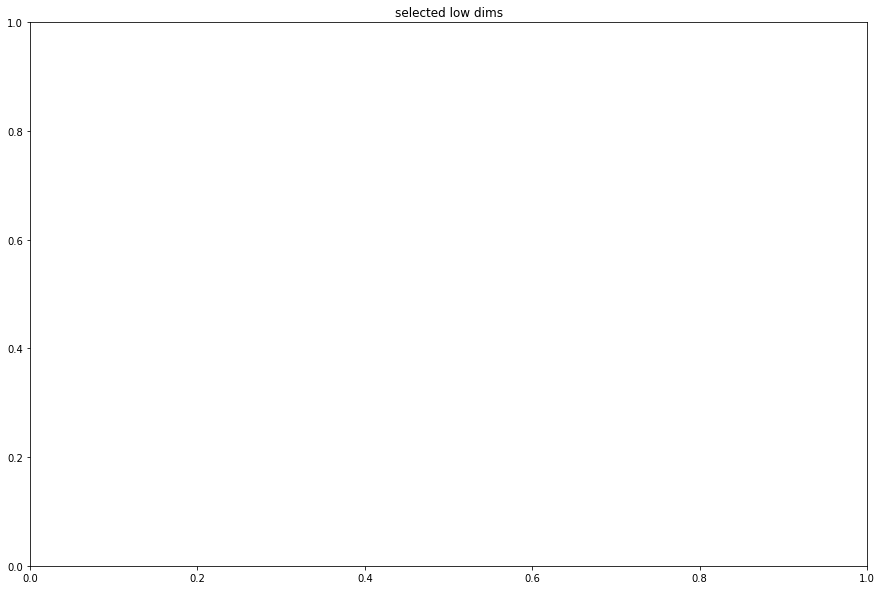

In [66]:
# interpolate from low dimensional space - any shape could go - no interpolation
@interact
def scatter_low_dim_filter_by_z(interpolate='0,0', col = df.columns, predict_flowfield=False):
    
    """
    Plot the low dimensional space of the VAE
    Interpolate and predict flowfields or volumes from that low dimensional space
    group the low dimensional space by the given meta data columns
    """
    m,n = interpolate.split(',')
    m = int(m)
    n = int(n)
    
    logging.info('selected x: {}'.format(m))
    logging.info('selected y: {}'.format(n))


    # create the first figure for the scatterplot overview
    fig, (ax1) = plt.subplots(1,1, figsize=(15,10))
    
    # figure one with a scatterplot of the low dimensional space
    ax1.set_title('selected low dims')
    ax1 = sns.scatterplot(df['z_mean_tsne_2'].map(lambda x : x[0]), df['z_mean_tsne_2'].map(lambda x : x[1]), hue=df[col], ax=ax1)
    ax1 =sns.scatterplot([m], [n], s=500, ax=ax1)
    
    # place the legend beside the plot
    legend_x = 1
    legend_y = 0.5
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0, box.width*0.65, box.height])
    ax1.legend( loc='center left', bbox_to_anchor=(legend_x, legend_y))
    
    if predict_flowfield:
        # interpolate from the low dimensional space, 
        # create a tuple from the selected low dim values 
        # and predict the flowfield for that parameters with the decoder part of the VAE
        low_dim = np.array([n,m])[np.newaxis,...]
        recon = decoder.predict(low_dim)

        if recon[0].shape[-1] == 1: # vizualize 2D or 3D volumes reconstructed from the decoder
            show_2D_or_3D(recon[0])

        else: # vizualize 2D flowmaps from reconstructed 3D flowfields
            fig, axes = plt.subplots(2,len(recon[0]),  figsize=(5*len(recon[0]), 8))
            axes_top = axes[0].flatten()
            axes_bottom = axes[1].flatten()
            for ax_t, ax_b, flow_slice in zip(axes_top, axes_bottom, recon[0]):
                ax_t.imshow(flow_slice); # plot vectors as rgb values with matplotlib
                ax_b = create_quiver_plot(flow_slice, ax_b) #create a 2D quiver plot per slice




# Scatterplot low dimensional space select by t_norm

In [97]:
# GCN data
@interact
def scatter_low_dim_filter_by_z(t=(df.t_norm.min(),df.t_norm.max())):
    temp = df[df['t_norm'] == t]
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    ax1 = sb.scatterplot(df['z_mean_tsne_2'].map(lambda x : x[0]), df['z_mean_tsne_2'].map(lambda x : x[1]), hue=df['t_norm'], ax=ax1)
    ax1.set_title('Overview\n Low dim representation, grouped by z')
    
    ax2 = sb.scatterplot(df['z_mean_tsne_2'].map(lambda x : x[0]), df['z_mean_tsne_2'].map(lambda x : x[1]), hue=df['patient'], ax=ax2, legend=False)
    sb.scatterplot(temp['z_mean_tsne_2'].map(lambda x : x[0]), temp['z_mean_tsne_2'].map(lambda x : x[1]), hue=df['patient'], s=500, ax=ax2, legend=False)
    ax2.set_title('Low dim representation\n marked t position = {}'.format(t))
    


interactive(children=(IntSlider(value=1, description='t', max=3), Output()), _dom_classes=('widget-interact',)…

# Scatterplot low dimensional space, group by Pathology - ACDC data

In [96]:

@interact
def scatter_low_dim_filter_by_patient(patient=sorted(df['patient'].unique())):
    
    temp = df[df['patient'] == patient]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,10))
    
    ax1 = sb.scatterplot(temp['z_mean_tsne_2'].map(lambda x : x[0]), 
                         temp['z_mean_tsne_2'].map(lambda x : x[1]), 
                         hue=df['t_norm'],
                         #hue=df['pathologie'], 
                         #style=temp['t_position'],
                         #size=temp['z_position'], 
                         sizes=(10,500), ax=ax1)
    ax1.set_title('Zoomed\n Low dim representation\n filtered by patient = {}'.format(patient))
    
    ax2 = sb.scatterplot(df['z_mean_tsne_2'].map(lambda x : x[0]), 
                         df['z_mean_tsne_2'].map(lambda x : x[1]), 
                         hue=df['t_norm'],
                         #hue=df['pathologie'], 
                         ax=ax2)
    ax2 = sb.scatterplot(temp['z_mean_tsne_2'].map(lambda x : x[0]), 
                   temp['z_mean_tsne_2'].map(lambda x : x[1]), 
                         hue=df['t_norm'],
                   #hue=df['pathologie'],
                         s=500, legend=False, ax=ax2)
    ax2.set_title('Overview\n Low dim representation\n marked patient = {}'.format(patient))
    
    # get all images, sort by t and than by z
    #images = sitk.GetArrayViewFromImage(sitk.ReadImage(temp.sort_values(by=['t_position', 'z_position'])['x_path'].values)) # acdc
    #print(images.shape)
    #plot_3d_vol(img_3d=images)
    #plt.show()

interactive(children=(Dropdown(description='patient', options=('04NEJQUZ', '0AE4R74L', '0HQQW4ZN', '0PTV75MP',…

# transform ACDC and GCN data with TSNE

In [ ]:
# concat gcn and acdc data, shrink dimensionality by TSNE
# concatenate both
z_mean_comb = np.concatenate([z_means_acdc, z_means_gcn])
logging.info(z_mean_comb.shape)
z_mean_comb_low_dim = TSNE(n_components=2, perplexity=100).fit_transform(z_mean_comb)
logging.info(z_mean_comb_low_dim.shape)

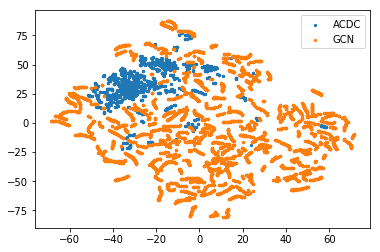

In [39]:
# scatter low dim vectors of acdc and gcn slices
plt.scatter(z_mean_comb_low_dim[:1856, 0], z_mean_comb_low_dim[:1856, 1], s=5, label='ACDC');
plt.scatter(z_mean_comb_low_dim[1856:, 0], z_mean_comb_low_dim[1856:, 1], s=5, label='GCN');
plt.legend()
plt.show();

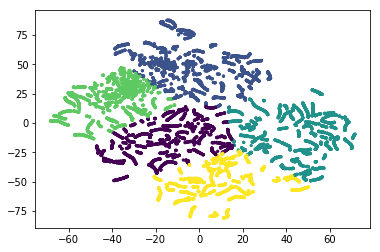

In [40]:
# find clusters with kmeans, after dimension reduction
from sklearn.cluster import KMeans
y_pred = KMeans(n_clusters=5, random_state=0).fit_predict(z_mean_comb_low_dim)
plt.scatter(z_mean_comb_low_dim[:, 0], z_mean_comb_low_dim[:, 1], c=y_pred, s=5)

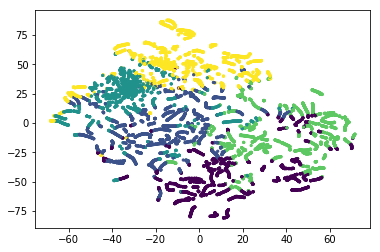

In [41]:
# find clusters with kmeans before dimension reduction
from sklearn.cluster import KMeans
y_pred = KMeans(n_clusters=5, random_state=0).fit_predict(z_mean_comb)
plt.scatter(z_mean_comb_low_dim[:, 0], z_mean_comb_low_dim[:, 1], c=y_pred, s=5)

In [60]:
# show all pathologies
df['pathologie'].unique()

array(['RV', 'NOR', 'MINF', 'HCM', 'DCM'], dtype=object)

In [97]:
# define colours
color_dict = { 'RV':'red', 'NOR':'blue', 'MINF':'black', 'HCM':'green','DCM':'purple' }
labels

array(['RV', 'RV', 'RV', ..., 'DCM', 'DCM', 'DCM'], dtype=object)

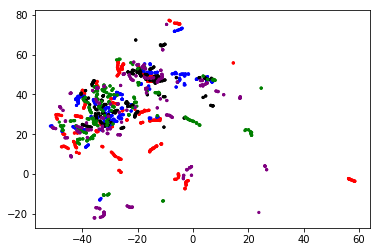

In [66]:
# group by pathologie
z_mean_comb_low_dim_gcn = z_mean_comb_low_dim[:1856, :]
#labels= df['pathologie'].astype('category').cat.codes.values
labels= df['pathologie'].values[:1856]
plt.scatter(z_mean_comb_low_dim_gcn[:, 0], z_mean_comb_low_dim_gcn[:, 1], c=[color_dict[i] for i in labels], s=5)

In [45]:
# inspect the gcn data set
@interact
def show_pred(img=(0,preds_gcn.shape[0])):
    print('selected: {}'.format(img))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # plot input and output
    ax1.imshow(x_trains_gcn[img,:,:,0])
    ax2.imshow(preds_gcn[img,:,:,0])
    
    # scatter low dim mean of this image
    f, ax3 = plt.subplots(1, 1, figsize=(10, 10))
    ax3.scatter(z_mean_comb_low_dim[:1856, 0], z_mean_comb_low_dim[:1856, 1], s=5, label='ACDC');
    ax3.scatter(z_mean_comb_low_dim[1856:, 0], z_mean_comb_low_dim[1856:, 1], s=5, label='GCN');
    z_mean_gcn_temp = z_mean_comb_low_dim[1856:, :]
    ax3.plot(z_mean_gcn_temp[img,0], z_mean_gcn_temp[img,1], 'r*', markersize = 20)
    ax3.legend()
    
    plt.show()

interactive(children=(IntSlider(value=5152, description='img', max=10304), Output()), _dom_classes=('widget-in…

In [28]:
df = df_folds[df_folds['fold'] == 1]
df.shape

(1884, 9)

In [30]:
df['x_path'].values

array(['data/raw/ACDC/2D/train/patient082_t01_z0_img.nrrd',
       'data/raw/ACDC/2D/train/patient082_t01_z10_img.nrrd',
       'data/raw/ACDC/2D/train/patient082_t01_z11_img.nrrd', ...,
       'data/raw/ACDC/2D/val/patient018_t10_z5_img.nrrd',
       'data/raw/ACDC/2D/val/patient018_t10_z6_img.nrrd',
       'data/raw/ACDC/2D/val/patient018_t10_z7_img.nrrd'], dtype=object)

In [46]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,fold,x_path,y_path,modality,patient,pathologie
896,896,896,0,1,data/raw/ACDC/2D/train/patient082_t01_z0_img.nrrd,data/raw/ACDC/2D/train/patient082_t01_z0_msk.nrrd,train,patient082,RV
897,897,897,1,1,data/raw/ACDC/2D/train/patient082_t01_z10_img....,data/raw/ACDC/2D/train/patient082_t01_z10_msk....,train,patient082,RV
898,898,898,2,1,data/raw/ACDC/2D/train/patient082_t01_z11_img....,data/raw/ACDC/2D/train/patient082_t01_z11_msk....,train,patient082,RV
899,899,899,3,1,data/raw/ACDC/2D/train/patient082_t01_z12_img....,data/raw/ACDC/2D/train/patient082_t01_z12_msk....,train,patient082,RV
900,900,900,4,1,data/raw/ACDC/2D/train/patient082_t01_z13_img....,data/raw/ACDC/2D/train/patient082_t01_z13_msk....,train,patient082,RV


In [ ]:
# tests
df = pd.read_csv('reports/acdc_2d_fold1_description.csv')
# transform string of list to list
df['z_mean_tsne_2'] = df['z_mean_tsne_2'].map(lambda x : [float(n) for n in x.strip('[]').split(',')])



In [33]:
img = sitk.GetArrayFromImage(sitk.ReadImage(df['x_path'].values[0]))

In [34]:
mask = sitk.GetArrayFromImage(sitk.ReadImage(df['y_path'].values[0]))

2019-09-25 16:30:02,941 INFO Image-shape: (154, 224)
2019-09-25 16:30:02,942 INFO Image data points: 34496
2019-09-25 16:30:02,943 INFO Image mean: 48.361
2019-09-25 16:30:02,943 INFO Image max: 255.000
2019-09-25 16:30:02,943 INFO Image min: 8.000
2019-09-25 16:30:02,943 INFO Mask-shape: (154, 224, 3)
2019-09-25 16:30:02,944 INFO RV mask data points: 1399
2019-09-25 16:30:02,945 INFO Myo mask data points: 562
2019-09-25 16:30:02,945 INFO LV mask data points: 819
2019-09-25 16:30:02,946 INFO RV mask 0.040555424988269806% of total pixels.
2019-09-25 16:30:02,946 INFO Myo mask 0.016291743144392967% of total pixels.
2019-09-25 16:30:02,946 INFO LV mask 0.023741882294416428% of total pixels.


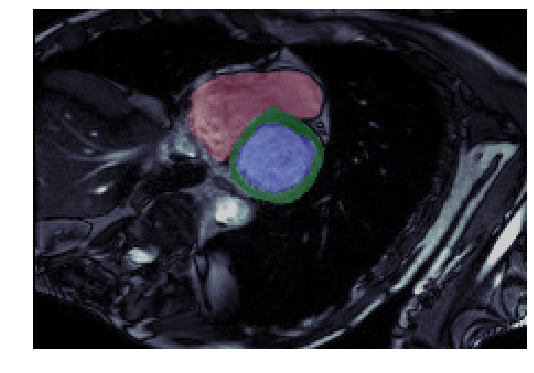

In [35]:
show_slice_transparent(img, mask)